**IMPORTING REQUIRED LIBRARIES**

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import cv2
import pathlib
import glob
import shutil
import os
import random


**IMPORTING THE DATA**

In [2]:
######################################### caution : terminal commands #######################################################

#-------------------------------------empty the datasets forlder before downloading the dataset -------------------------------------

%cd
%cd .keras/datasets/
!rm -r *

/root
/root/.keras/datasets


In [3]:
########################################### download data from given url ###############################################3

dataset_url = "https://storage.googleapis.com/wandb_datasets/nature_12K.zip"
data_dir = tf.keras.utils.get_file('nature_12K', origin=dataset_url, extract=True)


3816693760/3816687935 [==============================] - 44s 0us/step


**SPLITTING THE DATA**

In [4]:
#---------------------------------------------caution : terminal commands ----------------------------------------------

%cd
%cd .keras/datasets/inaturalist_12K
%mv val test
!mkdir valid

/root
/root/.keras/datasets/inaturalist_12K


In [5]:
#################################### split train data into validation set and training set ###################################

data_folder = '/root/.keras/datasets/inaturalist_12K'
os.chdir(data_folder)

folder_names = ['Amphibia', 'Animalia', 'Arachnida', 'Aves', 'Fungi', 'Insecta', 'Mammalia', 'Mollusca', 'Plantae', 'Reptilia' ]
for i in range(0,10):
  source = data_folder + "/train/" +folder_names[i]  
  orig_files = os.listdir(source)
  chosen_indexes = random.sample(range(0, len(orig_files)-1), 100)

  destination = data_folder + "/valid/"
  os.chdir(destination)
  os.system('mkdir'+' '+str(folder_names[i]))
  destination = destination + folder_names[i]
  for j in range(0,100):
    shutil.move(   source +"/" + str(   orig_files[   chosen_indexes[j]  ]   )  , destination)


In [6]:
####################################### Correcting the directory location ####################################################

#data_dir = '/root/.keras/datasets/nature_12K'

data_dir = data_dir.split('/')
data_dir.remove('nature_12K')
data_dir.append('inaturalist_12K')
data_dir = '/'.join(data_dir)


In [7]:
#-------------------------------------Taking the train data--------------------------------------------------------
train_data_dir_path = data_dir + '/train'
train_data_dir = pathlib.Path(train_data_dir_path)

#--------------------------------------Taking the validation data-----------------------------------------------
valid_data_dir_path = data_dir + '/valid'
valid_data_dir = pathlib.Path(valid_data_dir_path)

#----------------------------------------Taking the test data-----------------------------------------------
test_data_dir_path = data_dir + '/test'
test_data_dir = pathlib.Path(test_data_dir_path)

In [8]:
#------------------------------------------Parameters for the images-------------------------------------------------
batch_size = 32
img_height = 180
img_width = 180

In [9]:
####################################### converting the image data into dataset ############################################

#-------------------------------------training dataset -----------------------------------------------------
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_data_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
  )

#----------------------------------------------validation dataset -----------------------------------------------
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  valid_data_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
  )

Found 9000 files belonging to 10 classes.
Found 999 files belonging to 10 classes.


**CONVOLUTIONAL NEURAL NETWORK**

In [10]:
class CNN():

############################################# constructor for class CNN ##########################################
  def __init__(self, batch_size, img_height, img_width, filter_count, filter_size, active_func,dense_neurons_count,maxpool_size,output_neurons_count, optimizer='adam'):
    self.batch_size = batch_size
    self.img_height = img_height
    self.img_width = img_width
    self.filter_count = filter_count
    self.filter_size = filter_size
    self.active_func = active_func
    self.dense_neurons_count = dense_neurons_count
    self.maxpool_size = maxpool_size
    self.num_classes = output_neurons_count
    self.optimizer = optimizer
    self.model = self.create_model(5)


############################################### function to create model ####################################################
  def create_model(self, num_layers):

    #------------------creating a normalisation layer to be included in the model---------------------------------------
    normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)


    #-------------------------------------------creating the CNN model -----------------------------------------------------
    model = Sequential([
      layers.experimental.preprocessing.Rescaling(1./255, input_shape=(self.img_height, self.img_width, 3)),

      #----------------------------------------------layer 1---------------------------------------------------------------------
      layers.Conv2D(self.filter_count[0], self.filter_size[0], padding='same', activation = self.active_func[0]),
      layers.MaxPooling2D(pool_size = self.maxpool_size[0]),

      #-----------------------------------------------layer 2-----------------------------------------------------------------
      layers.Conv2D(self.filter_count[1], self.filter_size[1], padding='same', activation = self.active_func[1]),
      layers.MaxPooling2D(pool_size = self.maxpool_size[1]),

      #-----------------------------------------------layer 3-----------------------------------------------------------------
      layers.Conv2D(self.filter_count[2], self.filter_size[2], padding='same', activation = self.active_func[2]),
      layers.MaxPooling2D(pool_size = self.maxpool_size[2]),

      #-----------------------------------------------layer 4-----------------------------------------------------------------
      layers.Conv2D(self.filter_count[3], self.filter_size[3], padding='same', activation = self.active_func[3]),
      layers.MaxPooling2D(pool_size = self.maxpool_size[3]),

      #-----------------------------------------------layer 5-----------------------------------------------------------------
      layers.Conv2D(self.filter_count[4], self.filter_size[4], padding='same', activation = self.active_func[4]),
      layers.MaxPooling2D(pool_size = self.maxpool_size[4]),

      #-----------------------------------------------flattening-----------------------------------------------------------
      layers.Flatten(),

      #-----------------------------------------------fully connected layer----------------------------------------------------
      layers.Dense(self.dense_neurons_count,  activation = self.active_func[5]),

      #--------------------------------------------------output layer---------------------------------------------------------
      layers.Dense(self.num_classes)
    ])


    # ---------------------------------------compiling the CNN model ----------------------------------------------------------
    model.compile(
    optimizer = self.optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'] )


  #--------------------------------------------- return final model --------------------------------------------------------
    return model 


  
############################################## function for training the model ##################################################3
  def train(self, train_ds, val_ds, epochs = 10):

    #------------------------------------caching the datasets -----------------------------------------------
    AUTOTUNE = tf.data.AUTOTUNE
    train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
    val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

    #------------------------------------ training the model -----------------------------------------------
    history = self.model.fit( train_ds, validation_data=val_ds, epochs=epochs )
    return history

    


############################################ function for summary of model ###########################################3
  def model_summary(self):
    return self.model.summary()

#=============================================== end of class CNN ======================================================
    

In [15]:
############################################# function to visualize result ###########################################333#
def visualise_results(history, epochs):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

In [12]:
# (self, batch_size, img_height, img_width, num_filters, filter_size, active_func,dense_neurons_count,maxpool_size,output_neurons_count, optimizer='adam')
# train(self, train_ds, val_ds, epochs = 10)

batch_size = 32
img_height = 180
img_width = 180
filter_count = [16,32,64,64,64]
filter_size = [3,3,3,3,3]
maxpool_size = [2,2,2,2,2]
active_func = ['relu']*6
dense_neurons_count = 120
output_neurons_count = 10
epochs = 2

cnn = CNN(batch_size, img_height, img_width, filter_count, filter_size, active_func, dense_neurons_count, maxpool_size, output_neurons_count)

In [13]:
history = cnn.train(train_ds, val_ds, epochs)

Epoch 1/2
282/282 [==============================] - 364s 1s/step - loss: 2.2649 - accuracy: 0.1379 - val_loss: 2.1511 - val_accuracy: 0.1982
Epoch 2/2
282/282 [==============================] - 290s 1s/step - loss: 2.1524 - accuracy: 0.2128 - val_loss: 2.1049 - val_accuracy: 0.2472


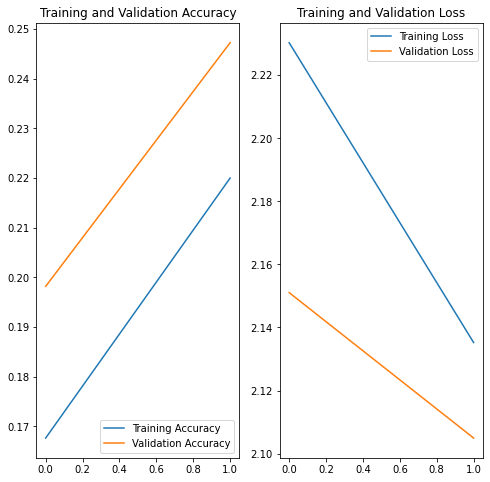

In [16]:
#------------------------------------visualising the results -----------------------------------------------
visualise_results(history, epochs)